# Prerequisites

In [43]:
!pip install qiskit
!pip install qutip
!pip install numpy
!pip install sqtdiat==0.0.0.3.14

In [44]:
import sqtdiat.qops as sq

In [3]:
import numpy as np
import sympy as sp 
import matplotlib.pyplot as plt
import qiskit as qt
from qiskit.visualization import plot_bloch_vector
import qutip as qt

In [4]:
def randm_dens():
    sig_x = np.array([[0, 1], [1, 0]])
    sig_y = np.array([[0, -1j], [1j, 0]])
    sig_z = np.array([[1, 0], [0, -1]])
    x, z = np.random.random() - 0.5, np.random.random() - 0.5
    y = (-1)**(np.random.randint(2)) * np.sqrt(1 - x**2 - z**2)
    return (np.eye(2) + x * sig_x + y * sig_y + z * sig_z) / 2

# 1 Normalize a statevector

In [42]:
def normalize_state_vec(state_vec):
    if type(state_vec) != np.array:
        state_vec = np.array(state_vec)
    norm_fact = 0
    for x in state_vec:
        norm_fact += x * np.conj(x)
    return 1 / np.sqrt(np.real(norm_fact)) * state_vec

normalize_state_vec([1 + 2j, 1 - 4j])

array([0.21320072+0.42640143j, 0.21320072-0.85280287j])

# 2 Gram-Schmidt Orthonormalization  of a Basis Set

In [6]:
def proj(v, u):
    if type(u) or type(v) != np.array:
        u, v = np.array(u), np.array(v)
    return np.dot(u, v) / np.dot(u, u) * u

def gram_schmidt(basis_set):
    if type(basis_set) != np.array:
        basis_set = np.array(basis_set)
    u = np.ones(basis_set.shape)
    u[0] = basis_set[0]
    for i in range(0, basis_set.shape[0]):
        subt = np.zeros(basis_set.shape[1])
        for j in range(0, i):
            subt = subt + proj(basis_set[i], u[j])
        u[i] = basis_set[i] - subt
        u[i] = u[i] / np.sqrt(np.dot(u[i], np.conj(u[i])))
    return u

gram_schmidt([[2, 2], [3, 5]])

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

# 3 Density Matrix associated with a statevector

In [7]:
def density_mat_from_state_vec(state_vec):
    if type(state_vec) != np.array:
        state_vec = np.array(state_vec)
    return np.dot(state_vec.reshape(state_vec.shape[0], 1), np.conj(state_vec.reshape(1, state_vec.shape[0])))

density_mat_from_state_vec(normalize_state_vec([1, 1j]))

array([[0.5+0.j , 0. -0.5j],
       [0. +0.5j, 0.5+0.j ]])

# 4 Find whether given n x n matrix is associated with a quantum system.

In [8]:
def trace(sqr_mat):
    if type(sqr_mat) != np.array:
        sqr_mat = np.array(sqr_mat)
    if sqr_mat.shape[0] == sqr_mat.shape[1]:
        return np.sum([sqr_mat[i][i] for i in range(sqr_mat.shape[0])])
    else:
        return "Entered matrix is not a square matrix."

def complex_conjugate(dens_mat):
    return np.conj(dens_mat).T

def nxn_valid_quantum(sqr_mat):
    if type(sqr_mat) != np.array:
        sqr_mat = np.array(sqr_mat)
    flag = True
    if np.sum(sqr_mat == complex_conjugate(sqr_mat)) != (sqr_mat.shape[0] * sqr_mat.shape[1]): 
        raise ValueError("The given matrix is not Hermitian")
    for x in np.linalg.eigvals(sqr_mat):
        if x < (-1 * 10**-4): flag = False; raise ValueError("Negative eigen values")
    if trace(sqr_mat) < 0.999 or trace(sqr_mat) > 1.0001: flag = False; raise ValueError("Trace is not equal to 1")
    if trace(np.dot(sqr_mat, sqr_mat)) > 1.0001: flag = False; raise ValueError("Trace of rho squared is greater than 1")
    return flag

nxn_valid_quantum(density_mat_from_state_vec(normalize_state_vec([1, -1j])))

True

In [9]:

a = np.array([[1, 2j], [-2j, 4]])
np.abs(np.sum(complex_conjugate(a) - a))

0.0

In [10]:
np.sum(np.array([[1, 2], [3, 4]]) - np.array([[1, 2], [3, 4]]))

0

In [11]:
nn = np.linalg.eigvals(density_mat_from_state_vec(normalize_state_vec([1, -1j])))
for x in nn:
    if x < (-1 * 10**-32): print(x, False)

# 5 Find whether given density matrix is pure or mixed state.

In [12]:
def pure_or_mixed(density_mat):
    if type(density_mat) != np.array:
        density_mat = np.array(density_mat)
    d_mat_sqr_trc = trace(np.dot(density_mat, density_mat))
    if d_mat_sqr_trc > 0.999 and d_mat_sqr_trc < 1.0001:
        return "pure"
    elif (d_mat_sqr_trc < 0.999) and (d_mat_sqr_trc > 0):
        return "mixed"
    else:
        return "Entered density matrix is invalid."

# pure_or_mixed(density_mat_from_state_vec(normalize_state_vec([1, 1, 1])))
pure_or_mixed([[0.5, 0], [0, 0.5]])

'mixed'

# 8 Partial Trace Operation of 2 qubit system

In [13]:
%%time

def partial_trace_2q(dens_mat, select_mat):
    if type(dens_mat) != np.array:
        dens_mat = np.array(dens_mat)
    if dens_mat.shape != (4, 4) and nxn_valid_quantum(dens_mat): return "Not a valid 2 qubit density matrix"
    if select_mat == "a" : return [[dens_mat[0][0] + dens_mat[2][2], dens_mat[0][1] + dens_mat[2][3]], [dens_mat[1][0] + dens_mat[3][2], dens_mat[1][1] + dens_mat[3][3]]]
    if select_mat == "b" : return [[dens_mat[0][0] + dens_mat[1][1], dens_mat[0][2] + dens_mat[1][3]], [dens_mat[2][0] + dens_mat[3][1], dens_mat[2][2] + dens_mat[3][3]]]

partial_trace_2q(density_mat_from_state_vec(normalize_state_vec([0, 1, -1, 0])) , "a")

CPU times: total: 0 ns
Wall time: 891 µs


[[0.4999999999999999, 0.0], [0.0, 0.4999999999999999]]

# ( ) Tensor Product of two matrices

In [14]:
%%time

n = 20
bbb = np.random.randn(n, n)

def tensor_prod(mat1, mat2):
    if type(mat1) != np.array or type(mat2) != np.array:
        mat1, mat2 = np.array(mat1), np.array(mat2)
    prod_mat = []

    # if len(mat1.shape) < 2:
        
    
    for i in range(mat1.shape[0]):
        for j in range(mat1.shape[1]):
            for k in range(mat2.shape[0]):
                for l in range(mat2.shape[1]):
                    prod_mat.append(mat1[i][k] * mat2[j][l])
    return np.array(prod_mat).reshape(mat1.shape[0] * mat2.shape[0], mat1.shape[1] * mat2.shape[1])

# print(np.kron([[1, 2], [3, 8]], [[1, 9], [0, 1]]))
print(tensor_prod(bbb, bbb))

[[ 2.26769422 -1.46960439  0.32834951 ...  1.08145136  0.62009704
   1.36293179]
 [ 1.81446708  1.79819431 -2.05115974 ... -0.81794716  0.52214222
  -0.29859596]
 [ 1.27718056 -0.25999014  0.03161849 ...  0.61054945 -0.59316389
   0.04539026]
 ...
 [-0.20435726  0.346898    0.71883651 ... -0.42401828  0.10489018
   0.89432316]
 [ 0.458415   -0.55951603  0.15649412 ... -1.762834   -2.94277103
  -0.06918863]
 [ 0.17743908  0.34126903 -0.09068977 ... -1.56934333 -0.39440071
   1.18083229]]
CPU times: total: 31.2 ms
Wall time: 90.9 ms


In [15]:
%%time
np.kron(bbb, bbb)

CPU times: total: 0 ns
Wall time: 1.4 ms


array([[ 2.26769422, -1.46960439,  0.32834951, ...,  1.08145136,
         0.62009704,  1.36293179],
       [ 1.81446708,  1.79819431, -2.05115974, ..., -0.81794716,
         0.52214222, -0.29859596],
       [ 1.27718056, -0.25999014,  0.03161849, ...,  0.61054945,
        -0.59316389,  0.04539026],
       ...,
       [-0.20435726,  0.346898  ,  0.71883651, ..., -0.42401828,
         0.10489018,  0.89432316],
       [ 0.458415  , -0.55951603,  0.15649412, ..., -1.762834  ,
        -2.94277103, -0.06918863],
       [ 0.17743908,  0.34126903, -0.09068977, ..., -1.56934333,
        -0.39440071,  1.18083229]])

$$\begin{pmatrix} 00|00 & 00|01 \end{pmatrix}$$

In [16]:
n = 4

def dec2bin(decc):
    bin_val = []
    ccv = decc
    while decc > 0:
        bin_val.append(str(decc % 2))
        decc //= 2
    while len(bin_val) < n:
        bin_val.append('0')
    l = "".join(bin_val[::-1])
    return f"{l[0:len(l) // 2]}:{l[len(l) // 2: len(l)]} {ccv}"

bb = []

i = 0
j = 0
while i < 2**n:
    bb.append(dec2bin(i))
    i += 1
    if i % 2 == 0 and j < 2:
        j += 1
        i = 0

bb = np.array(bb).reshape(2**2, 5)
print(len(bb), bb)

4 [['00:00 0' '00:01 1' '00:00 0' '00:01 1' '00:00 0']
 ['00:01 1' '00:10 2' '00:11 3' '01:00 4' '01:01 5']
 ['01:10 6' '01:11 7' '10:00 8' '10:01 9' '10:10 10']
 ['10:11 11' '11:00 12' '11:01 13' '11:10 14' '11:11 15']]


# Partial Trace using np.kron and np.matmul

In [17]:
 
 
#  a = np.kron(np.eye(2), [1, 0]) + np.kron(np.eye(2), [0, 1])
#  c = np.kron(np.eye(2), [[1], [0]]) + np.kron(np.eye(2), [[0], [1]])

#  b = [[0.5, 0, 0, 0.5], [0, 0, 0, 0], [0, 0, 0, 0], [0.5, 0, 0, 0.5]]

#  np.matmul(np.matmul(a, b), c)

def partial_trace_from_dm(matrix, pttr):
    basis = np.eye(2)
    # a = 1
    if type(matrix) != np.array:
        matrix = np.array(matrix)
    if nxn_valid_quantum(matrix):
        a_m = np.eye(matrix.shape[0])
        a_ = 0
        # b = np.zeros(len(pttr) * 2, matrix.shape[0])
        a = 1
        for i in range(int(np.log2(matrix.shape[0]))):
            if i + 1 in pttr:
                a = np.kron(a, basis[0])
                print(i)
            else:
                a = np.kron(a, basis)
        a_ += a
            
    # return np.matmul(np.matmul(a, matrix), c)
    return a_

partial_trace_from_dm(density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])), [1, 2, 4])

0
1
3


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
np.zeros((1, 2))

array([[0., 0.]])

# Partial Trace - Contd.



## Print only binary indices (000, 001, 100, 101, etc.)

Problem Statement.

You are given an array of integers and a number 'n'.

Eg: [1, 3]; n = 4

0000 - 0 \\
0001 - 1 \\
0100 - 4 \\
0101 - 5 \\

[2, 3, 5]; n = 6

000000 - 0 \\
000010 - 2 \\
000100 - 4 \\
000110 - 6 \\
010000 - 16 \\
010010 - 18 \\
010100 - 20 \\
010110 - 22

[1,4,6]; n = 6

000000 - 0 \\
000001 - 1 \\
001000 - 8 \\
001001 - 9 \\
100000 - 64 \\
100001 - 65 \\
101000 - 80 \\
101001 - 81

In [19]:
def tensor_frm_str(stri):
    a = 1
    for c in stri:
        if c == "-":
            a = np.kron(np.eye(2), a)
        elif c == "0":
            a = np.kron(np.eye(2)[0], a)
        else:
            a = np.kron(np.eye(2)[1], a)
    return a

cc = [1, 3]
n = 3

def binfrdec(dec, stdlen):
    k = []
    while dec > 0:
        k.append(str(dec % 2))
        dec //= 2
    while len(k) < stdlen:
        k.append(str(0))
    return k

def places(arr, cc, n):
    for i in range(n):
        if i in cc:
            arr.insert(i, "-")
    return "".join(arr[::-1])


def partial_trace_final_dm(dens_mat, cc):
    if type(dens_mat) != np.array:
        dens_mat = np.array(dens_mat)
    if nxn_valid_quantum(dens_mat):
        n = dens_mat.shape[0]
        a = 0
        for i in range(n):
            # a += tensor_frm_str(places(binfrdec(i, len(cc)), cc, n))
            print(a)
            print(places(binfrdec(i, len(cc)), cc, n))
        # return np.matmul(np.matmul(a, dens_mat), np.transpose(a))
        
partial_trace_final_dm(density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1])), [1])
# print(a)

0
-0
0
-1
0
1-0
0
1-1


In [20]:
%%time

pttx = [0, 1, 2]
tot = 10

kk = [2**i for i in pttx]
kk = kk[::-1]
jj = [2**i for i in range(tot) if i not in pttx]
jj = jj[::-1]

rho = density_mat_from_state_vec(normalize_state_vec([i for i in range(1, 2**tot + 1)]))

def binfromdec(number, rng):
    arr = []
    while number > 0:
        arr.append(str(number % 2))
        number //= 2 
    while len(arr) < rng:
        arr.append(str(0))
    return "".join(arr[::-1])


gg = []

for i in range(2**(tot - len(pttx))):
    str1 = binfromdec(i, tot - len(pttx))
    sum = 0
    for j in range(len(str1)):
        sum += int(str1[j]) * jj[j]
    gg.append(sum)

hh = []
for i in range(2**(len(pttx))):
    str1 = binfromdec(i, len(pttx))
    sum = 0
    for j in range(len(str1)):
        sum += int(str1[j]) * kk[j]
    hh.append(sum)
hh = np.array(hh)

ans = np.zeros((2**(tot - len(pttx)), 2**(tot - len(pttx))))
# print(np.shape(ans), ans)
# len(gg), len(hh), len(rho)
# print(gg, hh)

for i in range(len(hh)):
    
    ll = hh[i] + gg
    # print(ll, hh[i])
# ll = np.zeros((4, 1))
    for j in range(ans.shape[0]):
        for k in range(ans.shape[0]):
            ans[j][k] += rho[ll[j]][ll[k]]
         
    
print(trace(ans))
# rho[hh[4]][hh[1]]

1.0000000000000002
CPU times: total: 62.5 ms
Wall time: 116 ms


# Partial trace with Function

In [21]:
# %%time

pttx = [0, 1, 2]
tot = 10

kk = [2**i for i in pttx]
kk = kk[::-1]
jj = [2**i for i in range(tot) if i not in pttx]
jj = jj[::-1]

rho = density_mat_from_state_vec(normalize_state_vec([i for i in range(1, 2**tot + 1)]))

def binfromdec(number, rng):
    arr = []
    while number > 0:
        arr.append(str(number % 2))
        number //= 2 
    while len(arr) < rng:
        arr.append(str(0))
    return "".join(arr[::-1])

def weights(pttx, val):
    arr = []
    if val == 'a':
        str_val = tot - len(pttx)
        weights_mat = jj
    elif val == 'b':
        str_val = len(pttx)
        weights_mat = kk
    for i in range(2**str_val):
        str1 = binfromdec(i, str_val)
        sum = 0
        for j in range(len(str1)):
            sum += int(str1[j]) * weights_mat[j]
        arr.append(sum)
    return np.array(arr)

gg = weights(pttx, 'a')
hh = weights(pttx, 'b')

ans = np.zeros((2**(tot - len(pttx)), 2**(tot - len(pttx))))

for i in range(len(hh)):
    ll = hh[i] + gg
    for j in range(ans.shape[0]):
        for k in range(ans.shape[0]):
            ans[j][k] += rho[ll[j]][ll[k]]
         
    
print(trace(ans))

1.0000000000000002


# 2 qubit concurrence pure states

In [22]:
%%time

a = 1 / np.sqrt(2) * np.array([1, 0, 0, 1])
def concurrence(a):
    if type(a) != np.array:
        a = np.array(a)
    if len(a.shape) == 1:
        sig_y = [[0, 0, 0, -1], [0, 0, 1, 0], [0, 1, 0, 0], [-1, 0, 0, 0]]
        return ((a @ sig_y @ a.T)**2)

concurrence(a)

CPU times: total: 0 ns
Wall time: 0 ns


0.9999999999999996

In [23]:
number = 10

for i in range(2, number // 2 + 1):
    if number % i == 0:
        print("False")
        break

False


# PPT for n qubit system (Incomplete)

In [24]:
n = 2
dens_mat = density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1]))
# print( dens_mat)
ppt_dens = dens_mat
# ppt_dens = np.ones((2**n, 2**n)) * 10

#[0, 1, 4, 5] [2, 3, 6, 7]

def arr2num(arr):
    num = 0
    arr = arr[::-1]
    for i in range(len(arr)):
        num += arr[i] * 2**i
        # print(num, arr[i], i)
    return num

def dec2bin_num(num):
    bin = []
    while num > 0:
        bin.append(num % 2)
        num //= 2
    while len(bin) < n:
        bin.append(0)
    return bin[::-1]

def generate_bin(n):
    arr = []
    for x in range(2**n):
        arr.append(dec2bin_num(x))
    return arr

def ppt(dens_mat, qubit):
    if nxn_valid_quantum(dens_mat):
        n = int(np.log2(dens_mat.shape[0]))
        all_binary = generate_bin(n)
        all_binary_2 = generate_bin(n)
        part_qubit = n - qubit - 1
        cnt = 0
        orig = dens_mat
        ppt_dens = np.zeros((2**n, 2**n))
        for i in range(2**n):
            for j in range(2**n):
                if all_binary[i][part_qubit] != all_binary[j][part_qubit]:
                    dens_mat = orig
                    # old_i, old_j = arr2num(all_binary[i]), arr2num(all_binary[j])
                    all_binary_2[i][part_qubit], all_binary_2[j][part_qubit] = all_binary[j][part_qubit], all_binary[i][part_qubit]
#                     print(arr2num(all_binary[i]), arr2num(all_binary[j]), "New",arr2num(all_binary_2[i]), arr2num(all_binary_2[j]))
                    ppt_dens[arr2num(all_binary[i])][arr2num(all_binary[j])] = dens_mat[arr2num(all_binary_2[i])][arr2num(all_binary_2[j])]
                    # print(dens_mat, "\n", ppt_dens)
                else:
                    ppt_dens[i][j] = dens_mat[i][j]
        return ppt_dens

In [25]:
ppt(density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1])), 2)

array([[0.5, 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. ],
       [0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0.5]])

In [26]:
            # # print("Before", all_binary[i], all_binary[j], arr2num(all_binary[i]), arr2num(all_binary[j]), dens_mat[arr2num(all_binary[i]), arr2num(all_binary[j])])
            # all_binary_2[i][part_qubit], all_binary_2[j][part_qubit] = all_binary[j][part_qubit], all_binary[i][part_qubit]
            # print(all_binary, all_binary_2)
            # # print("After", all_binary_2[i], all_binary_2[j], arr2num(all_binary_2[i]), arr2num(all_binary_2[j]), dens_mat[arr2num(all_binary_2[i]), arr2num(all_binary_2[j])])
            # new_i, new_j = arr2num(all_binary_2[i]), arr2num(all_binary_2[j])
            # # print(ppt_dens[old_i][old_j], "Before", i, j )
            # dens_mat[old_i][old_j] = dens_mat[new_i][new_j]
            # # print(ppt_dens[old_i][old_j], "After" , i, j, "from", new_i, new_j)
            # # print("Old matrix\n", dens_mat)
            # # print("New matrix\n", ppt_dens)
            # # print(all_binary[i], all_binary[j], old_i, old_j, new_i, new_j)
dens_mat

array([[0.5, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0.5]])

In [27]:
%%time
n = 8
val = 10
dens_mat = density_mat_from_state_vec(normalize_state_vec([x % val for x in range(2**n)]))
for qubit in range(1, 2):
    
    all_binary = generate_bin(n)
    all_binary_2 = generate_bin(n)
    # qubit = 0
    part_qubit = n - qubit - 1
    cnt = 0
    # ppt_dens = dens_mat
    ppt_dens = []
    for i in range(2**n):
        for j in range(2**n):
            if all_binary[i][part_qubit] != all_binary[j][part_qubit]:
                #dens_mat = density_mat_from_state_vec(normalize_state_vec([x % val for x in range(2**n)]))
                # old_i, old_j = arr2num(all_binary[i]), arr2num(all_binary[j])
                all_binary_2[i][part_qubit], all_binary_2[j][part_qubit] = all_binary[j][part_qubit], all_binary[i][part_qubit]
                # print(arr2num(all_binary[i]), arr2num(all_binary[j]), "New",arr2num(all_binary_2[i]), arr2num(all_binary_2[j]))
                #ppt_dens[arr2num(all_binary[i])][arr2num(all_binary[j])] = dens_mat[arr2num(all_binary_2[i])][arr2num(all_binary_2[j])]
                ppt_dens.append(dens_mat[arr2num(all_binary_2[i])][arr2num(all_binary_2[j])])
                # print(dens_mat, "\n", ppt_dens)
            else:
                # print(i, j)
                #ppt_dens[i][j] = dens_mat[i][j]
                ppt_dens.append(dens_mat[i][j])
    ppt_dens = np.array(ppt_dens).reshape(2**n, 2**n)

    # print(ppt_dens)
    # plt.subplots(1, 2)
    # plt.imshow(dens_mat)
    # plt.subplot(1, 2, 2)
    # plt.imshow(ppt_dens)
# plt.imshow(ppt_dens)

CPU times: total: 78.1 ms
Wall time: 219 ms


In [28]:
def arr2num(arr):
    num = 0
    arr = arr[::-1]
    for i in range(len(arr)):
        num += arr[i] * 2**i
        # print(num, arr[i], i)
    return num

arr2num([1, 0])

2

# Concurrence of 2 qubit pure States for different probabilities

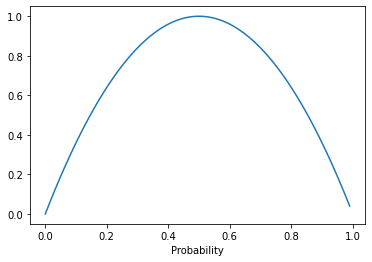

In [29]:
con_vals = []

for x in np.arange(0, 1, 0.01):
        con_vals.append(concurrence([np.sqrt(x), 0, 0, np.sqrt(1 - x)]))

# con_vals = np.array(con_vals).reshape(100, 100)
# plt.imshow(con_vals, cmap = 'binary')
plt.plot(np.arange(0, 1, 0.01), con_vals)
plt.xlabel("Probability")
# plt.axis('off')
plt.show()

# Linear Entropy

In [30]:
def linear_entropy(dens_mat):
    if type(dens_mat) != np.array:
        dens_mat = np.array(dens_mat)
    if nxn_valid_quantum(dens_mat):
        lin_en = 1 - trace(dens_mat @ dens_mat)
        if abs(lin_en) < 1 * 10**-15: 
            return 0
        else: 
            return lin_en

linear_entropy([[0.4, 0], [0, 0.6]])

0.48

# Stokes vector from density matrix for one qubit system

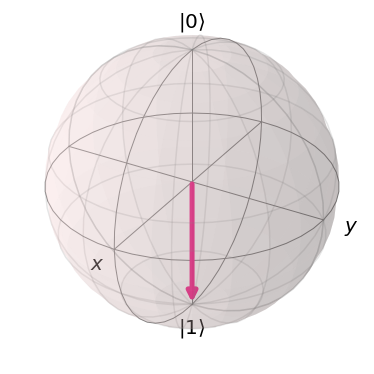

In [31]:
def stokes_vec_from_dens_mat(dens_mat):
    if type(dens_mat) != np.array:
        dens_mat = np.array(dens_mat)
    if nxn_valid_quantum(dens_mat):
        s0 = np.real(trace(dens_mat))
        s1 = np.real((trace(np.array([[0, 1], [1, 0]]) @ dens_mat)))
        s2 = np.real((trace(np.array([[0, -1j], [1j, 0]]) @ dens_mat)))
        s3 = np.real(trace(np.array([[1, 0], [0, -1]]) @ dens_mat))
        return [s0, s1, s2, s3]
    else: return False

# _, x, y, z = stokes_vec_from_dens_mat()

def plot_bloch_vector_from_dm(dens_mat):
    if stokes_vec_from_dens_mat(dens_mat) and nxn_valid_quantum(dens_mat):
        _, x, y, z = stokes_vec_from_dens_mat(dens_mat)
        return plot_bloch_vector([x, y, z])

plot_bloch_vector_from_dm(density_mat_from_state_vec(normalize_state_vec([0, 1])))
# # print(x, y, z)
# plot_bloch_vector([x, y, z])

# Stokes Vector for Two Qubit System

[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0]


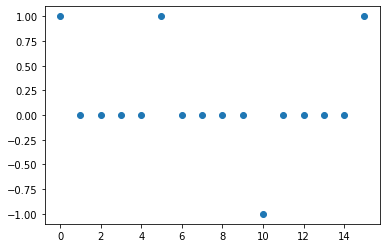

In [32]:
def stokes_two_qubit(dens_mat):
    if nxn_valid_quantum(dens_mat):
        if type(dens_mat) != np.array:
            dens_mat = np.array(dens_mat)
        pauli = [np.array([[1, 0], [0, 1]]), np.array([[0, 1], [1, 0]]), np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]])]
        stokes_vec = []
        for x in pauli:
            for y in pauli:
                stokes_vec.append(np.round(np.real(trace(np.kron(x, y) @ dens_mat)), 5))
                # print(np.kron(x, y))
        return stokes_vec

stokes_vec = stokes_two_qubit(density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1])))
print(stokes_vec)
plt.scatter(np.arange(16), stokes_vec)
plt.show()

#Von Neumann Entropy

$$-tr(\rho ln \rho)$$

In [33]:
def von_neumann(mat):
    if type(mat) != np.array:
        mat = np.array(mat)
    if nxn_valid_quantum(mat):
        eig_vals, eig_vecs = np.linalg.eig(mat)
        eig_vals = np.real(eig_vals)
        iden = np.eye(len(eig_vals))
        for i in range(len(eig_vals)):
            if abs(eig_vals[i]) < 10e-4:
                val = 0
            else:
                val = np.log2(eig_vals[i]) * eig_vals[i]
            iden[i] = -val * iden[i]
        return np.real(np.round(trace(np.linalg.inv(eig_vecs.T) @ iden @ eig_vecs.T), 4))

von_neumann(density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1])))

0.0

# Fidelity

$$tr({\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}}}^2)$$

In [34]:
def sqrt_dens_mat(dens_mat):
    # if nxn_valid_quantum(dens_mat):
    eig_vals, eig_vecs = np.linalg.eig(dens_mat)
    eig_vals = np.real(eig_vals)
    iden = np.eye(len(eig_vals))
    for i in range(len(eig_vals)):
        if np.abs(eig_vals[i]) < 10e-4:
            val = 0
        else:
            val = np.sqrt(eig_vals[i])
        iden[i] = val * iden[i]
    print(iden)
    return eig_vecs.T @ iden @ np.linalg.inv(eig_vecs.T)

def fidelity(rho1, rho2):
    if type(rho1) != np.array:
        rho1 = np.array(rho1)
    if type(rho2) != np.array:
        rho2 = np.array(rho1)
    if rho1.shape == rho2.shape:
        if nxn_valid_quantum(rho1) and nxn_valid_quantum(rho2):
            sqrt_rho1 = sqrt_dens_mat(rho1)
            val = sqrt_rho1 @ rho2 @ sqrt_rho1
            if np.imag(trace(val)) < 10e-4:
                return np.round(np.real((trace(sqrt_dens_mat(val)))**2), 4)
    else:
        print(f"Given density matrices are not of same dimension {rho1.shape}, {rho2.shape}")

fidelity(randm_dens(), np.array([[1, 0], [0, 0]]))

[[1. 0.]
 [0. 0.]]
[[0.88002038 0.        ]
 [0.         0.        ]]


0.7744

In [35]:
sqrt_dens_mat(density_mat_from_state_vec(normalize_state_vec([1, 0, 1, 0])))

[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


array([[ 0.5, -0.5,  0. ,  0. ],
       [-0.5,  0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ]])

In [36]:
bnnn = np.array([[1, 1j], [-1j, 1]])
np.linalg.eig(bnnn)[0], np.linalg.eigvalsh(bnnn) 

(array([2.+0.j, 0.+0.j]), array([0., 2.]))

# Trace Distance

In [37]:
%%time
def trace_distance(rho1, rho2):
    if type(rho1) != np.array:
        rho1 = np.array(rho1)
    if type(rho2) != np.array:
        rho2 = np.array(rho2)
    if nxn_valid_quantum(rho1) and nxn_valid_quantum(rho2):
        val = rho1 - rho2
        return np.real(trace(sqrt_dens_mat(val @ np.conj(val.T)))) / 2

trace_distance([[1, 0], [0, 0]], 0.5 * np.array([[1, -1j], [1j, 1]]))

[[0.70710678 0.        ]
 [0.         0.70710678]]
CPU times: total: 0 ns
Wall time: 0 ns


0.7071067811865476

In [38]:
# def dens_mat_from_thetaphi(theta, phi):
#     return [[np.cos(theta / 2)**2, np.exp(-1j * phi) * np.sin(theta / 2) * np.cos(theta / 2)], [np.exp(1j * phi) * np.sin(theta / 2) * np.cos(theta / 2), np.sin(theta / 2)**2]]

# trc_dist = []

# for theta in np.arange(0, np.pi, 0.1):
#     for phi in np.arange(0, np.pi * 2, 0.1):
#         trc_dist.append(trace_distance(dens_mat_from_thetaphi(0, 0), dens_mat_from_thetaphi(theta, phi)))
# plt.imshow(trc_dist.reshape(48, 42))
# plt.show()

# Trace Distance in Bloch Sphere

In [39]:
b = qt.Bloch()


# Concurrence for 2 qubit system

$$C(\rho) = \sqrt{\sqrt{\rho}\hat{\rho}\sqrt{\rho}}$$
where $\hat{\rho}$ is:

$$\hat{\rho} = \Sigma \rho^* \Sigma $$

In [40]:
# %%time
# def concurrence(dens_mat):
#     if type(dens_mat) != np.array:
#         dens_mat = np.array(dens_mat)
#     if nxn_valid_quantum(dens_mat) and dens_mat.shape[0] == 4 and dens_mat.shape[1] == 4:
#         eta = np.array([[0, 0, 0, -1], [0, 0, 1, 0], [0, 1, 0, 0], [-1, 0, 0, 0]])
#         fin = dens_mat @ eta @ dens_mat.T @ eta 
#         eig_val_arr = np.linalg.eigvals(fin)
#         r_v = sorted(eig_val_arr, reverse = True)
#         val = np.sqrt(r_v[0])
#         for x in range(1, 4):
#             val -= np.sqrt(r_v[x])
#         return max(0. , np.real(np.round(val, 4)))

def concurrence(dens_mat):
    if type(dens_mat) != np.array:
        dens_mat = np.array(dens_mat)
    if nxn_valid_quantum(dens_mat) and dens_mat.shape[0] == 4 and dens_mat.shape[1] == 4:
        eta = np.array([[0, 0, 0, -1], [0, 0, 1, 0], [0, 1, 0, 0], [-1, 0, 0, 0]])
        fin = dens_mat @ eta @ dens_mat.T @ eta 
        eig_val_arr = np.linalg.eigvals(fin)
        r_v = sorted(eig_val_arr, reverse = True)
        val = np.sqrt(r_v[0])
        minimum_eig = r_v[-1]
        for x in range(1, 4):
            val -= np.sqrt(r_v[x])
        return max(0. , np.real(np.round(val, 4)))

concurrence(density_mat_from_state_vec(normalize_state_vec([1, 0, -1, 0])))

0.0

# Entanglement from concurrence

$$E(\rho) = s\left( \dfrac{1+\sqrt{1-C^2(\rho)}}{2} \right)$$

$$s(x) = -xlog_2 x- (1-x)log_2(1-x)$$

In [41]:
def bin_ent(x):
    return -x * np.log2(x) - (1 - x) * np.log2(1 - x)

def ent(dens_mat):
    return bin_ent((1 + np.sqrt(1 - concurrence(dens_mat)[0]**2)) / 2)

ent(density_mat_from_state_vec(normalize_state_vec([1, -1j, -2j, 1])))

IndexError: invalid index to scalar variable.

# Density matrix associated with a stokes vector for 1 qubit and 2 qubit systems

In [ ]:
def dens_mat_from_stokes_vec(vec):
    s = [np.eye(2, dtype = 'complex128'), np.array([[0, 1], [1, 0]], dtype = 'complex128'), np.array([[0, -1j], [1j, 0]], dtype = 'complex128'), np.array([[1, 0], [0, -1]], dtype = 'complex128')]
    if len(vec) == 4:
        b = np.zeros((2, 2))
        for i in range(4):
            b = b + vec[i] * s[i]
        b = b / 2
    if len(vec) == 16:
        b = np.zeros((4, 4))
        for i in range(4):
            temp_num = 0
            for j in range(4):
                b = b + vec[4 * i + j] * np.kron(s[i], s[j])
        b = b / 4
        c = []
        for i in range(4):
            for j in range(4):
                if np.imag(b[i][j]) == 0:
                    c.append(np.real(b[i][j]))
                else:
                    c.append(b[i][j])
    return np.array(c).reshape(4, 4)



dens_mat_from_stokes_vec([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
c = []
for i in range(2000):c.append(2 * np.random.randint(2) - 1)
np.mean(c)

In [ ]:
cc = [[0.8, 1j], [-1j, 0.2]]
cc = np.array(cc)
# nxn_valid_quantum(cc)
np.sum(complex_conjugate(cc) == cc) == cc.shape[0] * cc.shape[1]

In [ ]:
b_1 = density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1]))
b_2 = density_mat_from_state_vec(normalize_state_vec([1, 0, 0, -1]))
b_3 = density_mat_from_state_vec(normalize_state_vec([0, 1, 1, 0]))
b_4 = density_mat_from_state_vec(normalize_state_vec([0, 1, -1, 0]))
con_mat = []
for i in np.arange(0, 0.5, 0.01):
    for j in np.arange(0, 0.5, 0.01):
        p1 = i
        p2 = j
        p3 = 0
        p4 = 1 - p3 - p2 - p1

        dens_mat_con_mix = p1 * b_1 + p2 * b_2 + p3 * b_3 + p4 * b_4
        if nxn_valid_quantum(dens_mat_con_mix):
            con_mat.append(concurrence(dens_mat_con_mix))
plt.figure(figsize = (10, 10))
# plt.plot(np.arange(0, 1, 0.01), con_mat)
plt.imshow(np.array(con_mat).reshape(50, 50))
plt.axis('off')
plt.show()

# Qubit Tomography Single

In [ ]:
def tomography_single_qubit(N_H, N_V, N_D, N_R):
    N_t = N_H + N_V
    P_H = N_H / N_t
    P_V = N_V / N_t
    P_D = N_D / N_t
    P_R = N_R / N_t
    return np.array([[2 * P_H, (2 * P_D - 1) - 1j * (1 - 2 * P_R)], [(2 * P_D - 1) + 1j * (1 - 2 * P_R), 2 * P_V]]) * 0.5

# tomography_single_qubit(1000, 0, 500, 500)


$$W = p\dfrac{I_4}{4} + (1-p) |\phi_+><\phi_+|$$

In [ ]:
wwer = []
nwer = []
f1 = False
for p1 in np.arange(0, 1, 0.001):
    bhbh = concurrence((1 - p1) * np.eye(4) / 4 + (p1) * density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1])))
    wwer.append(bhbh)

    if bhbh == 0 and f1 == False:
        print(bhbh, p1)
        f1 = True
    prev = bhbh

plt.plot(np.arange(0, 1, 0.001), wwer)
plt.show()

# 2 Qubit State Tomography

In [ ]:
bas = ['H', 'V', 'D', 'A', 'L', 'R']
sq_bas = []
for i in bas:
    for j in bas:
        sq_bas.append(str(i + j))
np.array(sq_bas).reshape(6, 6)

In [ ]:
# %%time
def tomography_two_qubit(arr):
    s = [np.eye(2, dtype = 'complex128'), np.array([[0, 1], [1, 0]], dtype = 'complex128'), np.array([[0, -1j], [1j, 0]], dtype = 'complex128'), np.array([[1, 0], [0, -1]], dtype = 'complex128')]
    N_tot = arr[0] + arr[1] + arr[4] + arr[5]
    S = []
    arr = np.array(arr) / N_tot
    PHH, PHV, PHD, PHL, PVH, PVV, PVD, PVL, PDH, PDV, PDD, PDL, PLH, PLV, PLD, PLL = arr 
    PHA = PHH + PHV - PHD
    PHR = PHH + PHV - PHL
    PVA = PVH + PVV - PVD
    PVR = PVH + PVV - PVL 
    PDA = PDH + PDV - PDD
    PDR = PDH + PDV - PDL
    PAH = PHH + PVH - PDH
    PRH = PHH + PVH - PLH
    PAV = PHV + PVV - PDV
    PRV = PHV + PVV - PLV
    PAD = PHD + PVD - PDD
    PRD = PHD + PVD - PLD
    PLA = PLH + PLV - PLD
    PLR = PLH + PLV - PLL
    PAL = PHL + PVL - PDL
    PRL = PHL + PVL - PLL
    PAA = 1 - PDD - PDA - PAD
    PAR = PAH + PAV - PAL
    PRA = PHA + PVA - PLA
    PRR = 1 - PRL - PLR - PLL 
    S.append(PHH + PHV + PVH + PVV)
    #S00 to 03
    S.append(PDD - PDA + PAD - PAA)
    S.append(PLL - PRL + PLR - PRR)
    S.append(PHH - PHV + PVH - PVV)

    S.append(PDD + PDA - PAD - PAA) #S10
    S.append(PDD - PDA - PAD + PAA) #S11
    S.append(PDL - PDR - PAL + PAR) #S12
    S.append(PDH - PDV - PAH + PAV) #S13
    S.append(PLL - PLR + PRL - PRR) #S20
    S.append(PLD - PLA - PRD + PRA) #S21
    S.append(PRR - PRL - PLR + PLL) #S22
    S.append(PLH - PLV - PRH + PRV) #S23
    S.append(PHH + PHV - PVH - PVV) #S30
    S.append(PHD - PHA - PVD + PVA) #S31
    S.append(PHL - PHR - PVL + PVR) #S32
    S.append(PHH - PHV - PVH + PVV) #S33
    b = np.zeros((4, 4))
    for i in range(4):
        temp_num = 0
        for j in range(4):
            b = b + S[4 * i + j] * np.kron(s[i], s[j])
            # if (S[4 * i + j]) > 0.001:
            # print(i, j, 4 * i + j)
    b = b / 4
    return np.round(np.real(b), 3)

tomography_two_qubit([333333, 166666, 250000, 250000, 166666, 333333, 250000, 250000, 250000, 250000, 333333, 250000, 250000, 250000, 250000, 166666])
# concurrence(tomography_two_qubit([3333, 1666, 2500, 2500, 1666, 3333, 2500, 2500, 2500, 2500, 3333, 2500, 2500, 2500, 2500, 1666]))
# nxn_valid_quantum(tomography_two_qubit([333333, 166666, 250000, 250000, 166666, 333333, 250000, 250000, 250000, 250000, 333333, 250000, 250000, 250000, 250000, 166666]))

In [ ]:
s = [np.eye(2, dtype = 'complex128'), np.array([[0, 1], [1, 0]], dtype = 'complex128'), np.array([[0, -1j], [1j, 0]], dtype = 'complex128'), np.array([[1, 0], [0, -1]], dtype = 'complex128')]
np.real(np.linalg.eig(np.kron(s[1], s[3]))[1]).T

In [ ]:
i = 1
j = 3
np.linalg.eig(np.kron(s[i], s[j]))[0], np.linalg.eig(np.kron(s[i], s[j]))[1].T * np.sqrt(2)

In [ ]:
m = ['D', 'A', 'L', 'R', 'H', 'V']
# m = ['D', 'L', 'H', 'V']
bb = np.empty([6, 6] ,dtype = object)
for i in range(len(m)):
    for j in range(len(m)):
        bb[i][j] = str(m[i] + m[j])
# print(bb)
bb[:, [2, 3]] = bb[:, [3, 2]]
bb[:, [2, 0]] = bb[:, [0, 2]]
bb[:, [1, 0]] = bb[:, [0, 1]]
bb[[2, 3], :] = bb[[3, 2], :]
bb[[2, 0], :] = bb[[0, 2], :]
bb[[1, 0], :] = bb[[0, 1], :]
# bb[:, [2, 1]] = bb[:, [1, 2]]
# bb[:, [0, 1]] = bb[:, [1, 0]]
# np.roll(bb, (-3, 0))
print(bb)
bb[:, [2, 0]] = bb[:, [0, 2]]
bb[:, [2, 1]] = bb[:, [1, 2]]
# 
bb[:, [2, 3]] = bb[:, [3, 2]]
bb[[2, 0], :] = bb[[0, 2], :]
bb[[2, 1], :] = bb[[1, 2], :]

bb[[2, 3], :] = bb[[3, 2], :]
print(bb)

In [ ]:
# np.set_printoptions(suppress=True,
#    formatter={'float_kind':'{:f}'.format})
np.set_printoptions(suppress=True)

def two_tomo(arr):
    s = [np.eye(2, dtype = 'complex128'), np.array([[0, 1], [1, 0]], dtype = 'complex128'), np.array([[0, -1j], [1j, 0]], dtype = 'complex128'), np.array([[1, 0], [0, -1]], dtype = 'complex128')]
    n_tot = arr[0] + arr[1] + arr[4] + arr[5]
    arr = np.array(arr) / n_tot
    PHH, PHV, PHD, PHL, PVH, PVV, PVD, PVL, PDH, PDV, PDD, PDL, PLH, PLV, PLD, PLL = arr

    arr_16_sq = np.array([[PDD, PDL, PDH, PDV], [PLD, PLL, PLH, PLV], [PHD, PHL, PHH, PHV], [PVD, PVL, PVH, PVV]])
    S_66 = np.zeros((6, 6))
    for i in range(len(S_66)):
        for j in range(len(S_66)):
            if i < 4 and j < 4:
                # print(i, j)
                S_66[i + 2][j + 2] = arr_16_sq[i][j]
    # print(S_66)
    for j in range(5, -1, -1):
        S_66[1][j] = S_66[j][5] + S_66[4][j] - S_66[3][j]
        S_66[0][j] = S_66[j][5] + S_66[4][j] - S_66[2][j]
    for i in range(5, -1, -1):
        S_66[i][1] = S_66[i][5] + S_66[i][4] - S_66[i][3]
        S_66[i][0] = S_66[i][5] + S_66[i][4] - S_66[i][2]
    # print(S_66)

    S_66[:, [2, 0]] = S_66[:, [0, 2]]
    S_66[:, [2, 1]] = S_66[:, [1, 2]]
    S_66[:, [2, 3]] = S_66[:, [3, 2]]
    S_66[[2, 0], :] = S_66[[0, 2], :]
    S_66[[2, 1], :] = S_66[[1, 2], :]
    S_66[[2, 3], :] = S_66[[3, 2], :]

    print(S_66)
    Stokes = np.zeros((16, 1))
    Stokes[0][0] = 1
    for i in range(4):
        for j in range(4):
            # if i != 
            if i != 0 and j != 0:
                # print(bb[(i - 1) * 2 : (i - 1) * 2 + 2, (j - 1) * 2: (j - 1) * 2 + 2], i, j, "next\n")
                temp_arr = np.array(S_66[(i - 1) * 2 : (i - 1) * 2 + 2, (j - 1) * 2: (j - 1) * 2 + 2]).reshape(1, 4)
                Stokes[i * 4 + j] = temp_arr @ np.array([1, -1, -1, 1]).reshape(4, 1)
            if i == 0 and j != 0:
                # print(bb[(j - 1) * 2 : j * 2, (j - 1) * 2: 2 * j], i, j, "next1\n")
                temp_arr = np.array(S_66[(j - 1) * 2 : j * 2, (j - 1) * 2: 2 * j]).reshape(1, 4)
                Stokes[i * 4 + j] = temp_arr @ np.array([1, -1, 1, -1]).reshape(4, 1)
            if i != 0 and j == 0:
                # print(bb[(i - 1) * 2 : i * 2, (i - 1) * 2: 2 * i], i, j, "next2\n")
                temp_arr = np.array(S_66[(i - 1) * 2 : i * 2, (i - 1) * 2: 2 * i]).reshape(1, 4)
                Stokes[i * 4 + j] = temp_arr @ np.array([1, 1, -1, -1]).reshape(4, 1)
    # Stokes = Stokes.reshape(16, 1) 
    b = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            b = b + Stokes[4 * i + j] * np.kron(s[i], s[j])
            # print(Stokes[4 * i + j], i, j)
    b = b / 4
    return np.round(np.real(b), 3)
    
two_tomo([333333, 166667, 250000, 250000, 166667, 333333, 250000, 250000, 250000, 250000, 333333, 250000, 250000, 250000, 250000, 166667])

In [ ]:
def werner(p):
    return (1 - p) * np.eye(4) / 4 + p * density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1]))
nevw = []
def negativity(dens_mat):
    if nxn_valid_quantum(dens_mat):
        transposed_dm = ppt(dens_mat, 2)
        eig_huy = np.linalg.eig(transposed_dm)[0]
        eig_huy.sort()
#         print(eig_huy)
#         if eig_huy[0] < 0:
        return max(0, -2 * eig_huy[0])
    
for p in np.arange(0, 1, 0.001):
    nevw.append(negativity(werner(p)))
#     print(negativity(werner(p)), p)

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.title("Concurrence")
plt.plot(np.arange(0, 1, 0.001), wwer)
plt.xlabel("p")
plt.subplot(1, 2, 2)
plt.title("Negativity")
plt.plot(np.arange(0, 1, 0.001), nevw)
plt.xlabel("p")
plt.show()

In [ ]:
np.linalg.eig(ppt(density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1])), 0))

In [ ]:
ppt(density_mat_from_state_vec(normalize_state_vec([1, 0, 0, 1])), 1)

In [ ]:
import sqt_diat as sq

In [ ]:
sq.normalize_state_vec([1, 2])

In [ ]:
def f(x):
    y = x**2
    return y

In [ ]:
f(10)